# Monte Carlo Variance Reduction Methods - Control Variates

<b> YouTube Tutorial </b> (Published:
Feb 4, 2022): https://youtu.be/2uTVahxdqek

In this tutorial we will investigate ways we can reduce the variance of results from a Monte Carlo simulation method when valuing financial derivatives. The mathematic notation and examples are from Les Clewlow and Chris Strickland's book Implementing Derivatives Models.

Unfortunately, although a great method for approximating option values with complex payoffs or high dimensionality, in order to get an acceptably accurate estimate we must perform a large number of simulations M. Instead we can lean on Variance Reduction methods which work on the same principles as that of hedging an option position. i.e. the variability of a hedged option portfolio will have a smaller variance that that of it's unhedged counterpart.

In [ ]:
## This is required for google colab
!pip install py_vollib

     |████████████████████████████████| 130 kB 10.3 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=6e0fa3214b50d91bf28e8d28ca29d62bab06835c3a54d9da5418bdb3e4052ff3
  Stored in directory: /root/.cache/pip/wheels/2d/25/50/bc80b93c9a827ed9bef9d86f85365e1934bcbc0666b9f00c11
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24468 sha256=c4f9d71cd6bbd0569abcff69765a66666e535f7577812a3fc23ac64c582832da
  Stored in directory: /root/.cache/pip/wheels/1a/70/10/bf54a16badc528594c9510ef517badb765a29b651ea5652898
Successfully built py-vollib py-lets-be-rational


In [ ]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

## Control Variates & Hedging

The probability distribution of an option pay-off after delta hedging has a smaller standard deviation compared to its portfolio's unhedged counterpart. We have shown this in a previous video, link above. Let's consider the dynamics of a discretely rebalanced delta hedge:

$\large C_{t_0}\exp{rT} - [\sum^{N}_{i=0} ( \frac{\delta C_{t_i}}{\delta S} - \frac{\delta C_{t_{i-1}}}{\delta S} ) S_t\exp{r(T-t_i)}] = C_T + \eta$

The first term is the forward value of the premium recieved for writing the option, the second term represents the cash flows from rebalancing the headge at each time $t$, and the third term is the pay-off of the option and the hedging error $\eta$.

Now if we expand the terms in the square brackets:

$\frac{\delta C_{t_0}}{\delta S}S_{t_0}\exp{r(T-t_0)} + \frac{\delta C_{t_1}}{\delta S}S_{t_0}\exp{r(T-t_1)} + ... + \frac{\delta C_{t_{N-1}}}{\delta S}S_{t_{N-1}}\exp{r(T-t_{N-1})} + \frac{\delta C_N}{\delta S}S_{t_N}$

$-\frac{\delta C_{t_0}}{\delta S}S_{t_1}\exp{r(T-t_1)} - \frac{\delta C_{t_1}}{\delta S}S_{t_2}\exp{r(T-t_2)} - ... - \frac{\delta C_{t_{N-1}}}{\delta S}S_N$

Group terms with $\frac{\delta C_{t_i}}{\delta S}$ at the same time steps.

$-\frac{\delta C_{t_0}}{\delta S}(S_{t_1}-S_{t_0}\exp{r\Delta t})\exp{r(T-t_1)} - \frac{\delta C_{t_1}}{\delta S}(S_{t_2}-S_{t_1}\exp{r\Delta t})\exp{r(T-t_2)} - ... - \frac{\delta C_{t_{N-1}}}{\delta S}(S_{t_N}-S_{t_{N-1}}\exp{r\Delta t}) + \frac{\delta C_N}{\delta S}S_{t_N}$

If we assume the last term equals 0, which is equivalent to not buying the final delta amount of the asset, but simpluing liquidating the underlying holdings from the previous rebalancing date into cash, then the portfolio becomes:

$\large C_{t_0}\exp{rT} = C_T - [\sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\Delta S}(S_{t_{i+1}} - S_{t_i}\exp{r\delta t})\exp{r(T-t_{i+1})} ] + \eta$

The term in the square brackets (the delta hedge) is a delta-based martingale control variate ($cv_1$). This can be written as:

$\large cv_1 = \sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\delta S}(S_{t_{i+1}} - {\mathbb E}[S_{t_i}])\exp{r(T-t_{i+1})}$

$\large C_{t_0}\exp{rT} = C_T - cv_1 + \eta$

## Gamma Based Control Variate

The control variate is a random variable whose expected value we know, which is correlated with the varaible we are trying to estimate.

In the same way as for $cv_1$ we can create other control variates, which are equivalent to other hedges.

For example a gamma-based control variate ($cv_2$):

$\large cv_2 = \sum^{N-1}_{i=0} \frac{\delta^2 C_{t_i}}{\delta S^2}((\Delta S_{t_{i+1}})^2 - {\mathbb E}[(\Delta S_{t_i})^2])\exp{r(T-t_{i+1})}$

Where ${\mathbb E}[(\Delta S_{t_i})^2] = S_{t_i}^2 (\exp([2r+\sigma^2]\Delta t_i)-2\exp(r\Delta t_i)+1)$

## General Control Variate Equation

For J control variates we have:

$ \Large C_0\exp(rT) = C_T - \sum^J_{i=j}\beta_j cv_j + \eta$

where
- $\beta_j$ are factors to account for the "true" linear relationship between the option pay-off and the control variate $cv_j$
- $\eta$ accounts for errors:
    - discrete rebalancing
    - approximations in hedge sensitivities (calc. delta / gamma)
    
    
Option price as the sum of the linear relationships with J control variates
    
$ \large C_T =\beta_0 + \sum^J_{i=j}\beta_j cv_j + \eta$

where $\beta_0 = C_0\exp(rT)$ is the forward price of the option

If we perform M simulations at discrete time intervals N we can regard the pay-offs and control variates as samples of the linear relationship with some noise. We can estimate the true relationship between control variates and option pay-offs with least-squares regression:

$\beta = (X'X)^{-1}X'Y$

We don't want biased estimates of $\beta_j$ so these should be precomputed by least-squares regression to establish the relationship between types of control variates and options first. These estaimates of $\beta_j$ values can then be used for $cv_j$ for pricing any option.  

## Implementation of Delta-based Control Variates

$\large cv_1 = \sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\delta S}(S_{t_{i+1}} - {\mathbb E}[S_{t_i}])\exp{r(T-t_{i+1})}$

$\large C_{t_0}\exp{rT} = C_T + \beta_1 cv_1 + \eta$


where with GBM dynamics:
- ${\mathbb E}[S_{t_i}] = S_{t_{i-1}} \exp (r \Delta t_i)$
- $\beta_1 = -1$ which is the appropriate value where we have exact delta for European Option

In [ ]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


## Slow Solution - Steps
Here we simulate stock price $St$ directly because we require this value during the calculation to determine the $delta$.

In [ ]:
# Precompute constants
N = 10
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)

beta1 = -1

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    St = S
    cv = 0
    for j in range(N):
        epsilon = np.random.normal()
        deltaSt = delta('c', St, K, T-j*dt, r, vol)
        Stn = St*np.exp( nudt + volsdt*epsilon )
        cv = cv + deltaSt*(Stn - St*erdt)
        St = Stn

    CT = max(0, St - K) + beta1*cv
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.82 with SE +/- 0.01


## Fast Solution - Vectorized

- Only 1 Step is Necessary in this example!

In [ ]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = stats.norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -stats.norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [ ]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,0,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)


CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
# CT = np.maximum(0, ST[-1] - K)
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.8 with SE +/- 0.027


### Compare without Delta-based Control Variate

In [ ]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)

CTw = np.maximum(0, ST[-1] - K)
C0w = np.exp(-r*T)*np.sum(CTw)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CTw - C0w)**2) / (M-1) )
SEw = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0w,2),np.round(SEw,3)))

Call value is $3.83 with SE +/- 0.107


# Visualisation of Convergence

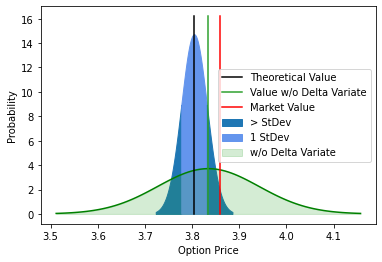

In [ ]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Delta Variate')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Delta Variate')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()